In [1]:
!pip install stellargraph

     |████████████████████████████████| 440kB 17.3MB/s 


In [2]:
import glob
import itertools
from os.path import join
import pickle
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import stellargraph as sg
import tensorflow as tf
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from stellargraph import StellarGraph
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT, GCN
from tensorflow.keras import layers, models, optimizers, losses, metrics, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from torch.utils import data as data_utils
from tqdm import tqdm

from google.colab import drive

tqdm.pandas()

## Setting seed value

In [3]:
seed_value = 1234

tf.random.set_seed(seed_value)
np.random.seed(seed_value)

## Mount Google Drive

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


## Data loading and preparing

In [5]:
# with open("/content/drive/Shareddrives/GCN-PROJECT/top_1000_nouns.pickle", "rb") as f:
#     top_nouns = pickle.load(f)

with open("/content/drive/Shareddrives/GCN-PROJECT/top_40_specific_nouns.pickle", "rb") as f:
    top_nouns = pickle.load(f)

data = pd.read_csv("/content/drive/Shareddrives/GCN-PROJECT/wiki_pages_lemmas.csv", index_col=0)

annotations = pd.read_csv("/content/drive/Shareddrives/GCN-PROJECT/annotations.csv", header=None)

w2v_vectors = pd.read_csv('/content/drive/Shareddrives/GCN-PROJECT/word2vec_lemmas.csv', index_col=0)

ft_vectors = pd.read_csv('/content/drive/Shareddrives/GCN-PROJECT/fasttext_lemmas.csv', index_col=0)

In [6]:
ft_vectors.shape[0]

177370

In [7]:
top_nouns_list = list(top_nouns.values())

top_nouns_flatten = [item 
                     for sublist in top_nouns_list 
                     for item in sublist]

top_nouns = set(top_nouns_flatten)

In [8]:
w2v_vectors = w2v_vectors[
    w2v_vectors['lemma'].isin(top_nouns)
]

ft_vectors = ft_vectors[
    ft_vectors['lemma'].isin(top_nouns)
]

In [9]:
ft_vectors.shape[0]

275

In [10]:
data.head()

,title,text,category,noun_lemmas
0,Mirosław_Miller,Mirosław Miller – Dyrektor Międzynarodowego La...,Chemia,"['mirosława', 'miller', 'dyrektor', 'laborator..."
1,Chimerokształtne,"Chimerokształtne, chimery, przerazy (Chimaerif...",Biologia,"['chimera', 'przeraza', 'chimaeriformes', 'rzą..."
2,(2855)_Bastian,(2855) Bastian (1931 TB2) – planetoida z grupy...,Astronomia,"['bastian', 'tb2', 'planetoida', 'grupa', 'pas..."
3,Cryptocephalus_celtibericus,"""Cryptocephalus celtibericus"" – gatunek chrząs...",Biologia,"['cryptocephalus', 'celtibericus', 'gatunek', ..."
4,Język_maszynowy,"Język maszynowy, kod maszynowy – zestaw rozkaz...",Matematyka,"['język', 'koda', 'zestaw', 'rozkaz', 'proceso..."


In [11]:
data['title'] = data['title'].progress_apply(
    lambda title: 'art_' + title
)

100%|██████████| 75792/75792 [00:00<00:00, 813668.76it/s]


In [12]:
annotations[0] = annotations[0].progress_apply(
    lambda title: 'art_' + title
)

annotations[1] = annotations[1].progress_apply(
    lambda title: 'art_' + title
)

100%|██████████| 1086032/1086032 [00:01<00:00, 1071681.86it/s]


### Graph building (nodes)

In [13]:
# w2v_vectors['vec'] = w2v_vectors['vec'].progress_apply(
#     lambda row: row[1:-1].replace('\'', '').split(', ')
# )

# ft_vectors['vec'] = ft_vectors['vec'].progress_apply(
#     lambda row: row[1:-1].replace('\'', '').split(', ')
# )

In [14]:
# vec column to list
w2v_vectors['vec'] = w2v_vectors['vec'].progress_apply(
    lambda vec: np.array(
        list(
            map(
                lambda x: float(x),
                vec[1:-1].split()
            )
        )
    )
)

ft_vectors['vec'] = ft_vectors['vec'].progress_apply(
    lambda vec: np.array(
        list(
            map(
                lambda x: float(x),
                vec[1:-1].split()
            )
        )
    )
)

100%|██████████| 275/275 [00:00<00:00, 25749.16it/s]


In [15]:
type(ft_vectors['vec'].iloc[0][0])

numpy.float64

In [16]:
# for w2v_vectors
w2v_node_data = w2v_vectors[['lemma', 'vec']]

features_columns = ['x'+str(i+1) for i in range(w2v_node_data.iloc[0]['vec'].shape[0])]

w2v_node_data[features_columns] = pd.DataFrame(w2v_node_data['vec'].tolist(), index=w2v_node_data.index)
w2v_node_data = w2v_node_data.drop_duplicates(subset=['lemma'])
w2v_node_data = w2v_node_data.set_index('lemma', drop=True)

w2v_node_data = w2v_node_data.drop(columns=['vec'])

# for ft_vectors
ft_node_data = ft_vectors[['lemma', 'vec']]

features_columns = ['x'+str(i+1) for i in range(ft_node_data.iloc[0]['vec'].shape[0])]

ft_node_data[features_columns] = pd.DataFrame(ft_node_data['vec'].tolist(), index=ft_node_data.index)
ft_node_data = ft_node_data.drop_duplicates(subset=['lemma'])
ft_node_data = ft_node_data.set_index('lemma', drop=True)

ft_node_data = ft_node_data.drop(columns=['vec'])

In [17]:
print(ft_node_data.shape)
ft_node_data.head()

(275, 100)


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,...,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100
lemma,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cov,-0.134785,-5.174409,0.072715,-0.393995,0.625206,3.648595,1.706848,-1.199129,-3.850186,1.241178,5.133821,-4.388796,0.411990,-3.123656,2.579663,0.513147,-7.471986,-1.337933,2.077371,-3.506273,1.185308,3.611973,1.038963,1.410728,-5.026603,3.092698,0.542444,3.983235,0.852252,-4.586207,3.239587,8.704684,2.551154,7.491611,-1.790033,-3.288949,-2.967883,1.739674,6.794806,3.329458,...,4.492099,-2.821524,-5.783140,0.321881,4.886373,-3.853077,0.900931,-0.464825,4.950966,1.841468,1.489587,-3.132951,2.329207,0.233915,1.785222,-0.276298,-4.410146,-4.014625,-4.835362,3.353456,0.365635,0.595311,3.300140,0.753344,-2.556859,2.963007,-1.125892,-2.794676,5.093818,0.224039,6.387025,0.718411,9.137869,3.995733,2.526868,-5.013382,5.224316,-2.534800,0.077053,3.723005
teleskop,-0.519775,-3.291218,-3.474434,2.937663,2.160233,0.121245,-3.596698,-0.507043,4.098453,3.941212,-0.762075,-0.299561,2.864712,-1.501972,-2.659664,1.276492,-1.338290,1.184389,3.226298,-2.373801,3.023208,2.531691,-5.763041,0.553811,-0.559893,-1.025842,3.268556,-1.129445,-3.989276,-4.985370,-0.466949,3.185346,-1.106984,3.794022,-1.436331,0.581364,-0.000812,-2.205852,9.454061,1.226963,...,-0.928754,-2.650989,-0.070226,1.506689,-2.759318,-0.217461,0.632674,-1.968322,2.754841,4.931026,4.680443,-1.509021,1.271528,5.389385,7.126800,-0.102990,-4.282376,0.446111,0.235192,-2.397161,-2.658066,-1.785686,0.729218,-2.252807,-1.541145,-3.158397,5.060914,-0.152916,0.398225,1.716584,4.386591,-1.042770,-1.436165,4.089646,-0.877424,-4.017228,0.951201,-1.946672,0.440949,0.266324
dinozaur,0.829511,-0.843005,-0.542812,0.821733,2.433965,-0.057087,-0.317324,-1.235993,-1.016550,3.811534,-4.233574,-0.728519,6.171540,-1.276793,-1.884577,-1.403679,1.639530,4.051808,2.055808,1.042725,1.831903,1.871657,-1.742453,1.468604,-1.754701,-0.838638,-1.477313,0.144593,-2.829981,-1.954050,-1.203935,4.090516,-1.031695,-1.417534,-0.219511,2.677310,-0.738279,-2.053681,5.166912,1.772741,...,-1.750917,3.140184,-0.490816,-0.637393,-2.303016,0.826507,1.242334,0.504386,-0.862252,2.694380,1.879492,-0.188263,2.447496,0.877043,4.604736,-1.323373,-0.983253,0.670222,-2.721287,3.859284,-3.408972,-1.666046,-0.230503,0.673435,-1.457718,-1.358367,0.920219,-2.441532,0.412175,2.527636,2.486934,1.297569,-0.328112,0.213191,0.096756,0.076846,0.139227,0.270865,3.264943,0.843603
chrząszcz,0.314197,-1.931222,-0.951336,1.280560,3.228989,-2.291156,-0.500783,-0.714286,-0.791675,2.747341,-1.427832,-0.990415,4.708677,-3.002465,-1.050361,-0.233225,-1.968563,2.780617,2.240143,-3.293432,1.951081,2.883475,-4.330312,2.028734,-0.736985,0.678190,-2.362673,0.205255,-2.231056,-4.272431,-1.325887,3.624873,0.276868,-0.732411,-2.036269,2.531929,0.668133,-0.394341,6.937645,1.363912,...,-0.667978,-0.013967,-1.485408,0.440541,-2.375478,2.903310,-2.577429,1.676182,1.015766,-1.051331,3.743315,0.145436,3.590937,-0.485986,3.090218,-1.800840,-2.372863,1.176508,-2.723169,0.604966,-2.903466,-0.146150,2.979370,-0.491440,-1.375820,-4.670910,3.679246,-1.952632,-0.325973,0.223513,1.605382,2.053384,-0.671868,0.548870,1.378246,-2.658252,-2.180688,1.965928,0.944971,2.556431
komedia,2.021255,-1.035194,-1.047785,-0.727976,2.136025,1.476739,-1.014887,0.348152,-1.658789,5.832660,3.258657,-2.395986,0.148591,2.759685,3.694361,-2.532171,3.459618,2.325811,-0.354329,0.998821,4.764869,1.400590,0.416346,-2.478596,-0.365823,3.228466,-1.033689,0.526555,-1.880090,-2.903807,1.025318,0.475351,2.870532,2.833204,-3.207674,-3.082818,-0.877148,-4.745919,5.976822,2.595371,...,-0.968665,-3.794404,0.910162,-0.253330,-1.752463,-1.425871,-3.123914,-0.727470,2.096141,5.818215,-0.855660,0.971075,2.837759,-

In [18]:
article_node_data = data[['title', 'category']]

features_columns = ['x'+str(i+1) for i in range(100)]

article_node_data[features_columns] = pd.DataFrame(np.zeros([data.shape[0], 100]), index=article_node_data.index)
article_node_data = article_node_data.drop_duplicates(subset=['title'])
article_node_data = article_node_data.set_index('title', drop=True)

article_node_subjects = article_node_data['category']
article_node_data = article_node_data.drop(columns=['category'])

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [19]:
print(article_node_data.shape)
article_node_data.head()

(75649, 100)


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,...,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
art_Mirosław_Miller,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
art_Chimerokształtne,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
art_(2855)_Bastian,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
art_Cryptocephalus_celtibericus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
art_Język_maszynowy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
article_node_subjects.head()

title
art_Mirosław_Miller                    Chemia
art_Chimerokształtne                 Biologia
art_(2855)_Bastian                 Astronomia
art_Cryptocephalus_celtibericus      Biologia
art_Język_maszynowy                Matematyka
Name: category, dtype: object

### Graph building (edges)

In [21]:
edges_articles = annotations
edges_articles.columns = ['source', 'target']

nodes_set = set(article_node_data.index)
edges_articles = edges_articles[
    (edges_articles['source'].isin(nodes_set)) &
    (edges_articles['target'].isin(nodes_set))
]

In [22]:
# TMP
# data = pd.read_csv("/content/drive/Shareddrives/GCN-PROJECT/wiki_pages_lemmas.csv", index_col=0)

In [23]:
# # Encode target labels with value between 0 and n_classes-1
# le = LabelEncoder()
# le.fit(data['category'].tolist())
# labels = le.transform(data['category'].tolist())

# data['category'] = labels

# data.head()

In [24]:
data = data.drop_duplicates(subset=['title'])
data = data.reset_index(drop=True)

In [25]:
data['noun_lemmas'] = data['noun_lemmas'].progress_apply(
    lambda row: row[1:-1].replace('\'', '').split(', ')
)

100%|██████████| 75649/75649 [00:01<00:00, 48556.49it/s]


In [26]:
# word_nodes = set(w2v_node_data.index)
word_nodes = set(ft_node_data.index)

In [27]:
data['noun_lemmas'] = data['noun_lemmas'].progress_apply(
    lambda lemmas: list(set([lemma for lemma in lemmas if lemma in word_nodes]))
)

100%|██████████| 75649/75649 [00:00<00:00, 108390.66it/s]


In [28]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

In [29]:
edges_words = data[['title', 'noun_lemmas']]
edges_words.columns = ['source', 'target']

edges_words = explode(
    df=edges_words, 
    lst_cols=['target'], 
    fill_value=''
)

article_nodes = set(article_node_data.index)
edges_words = edges_words[
    (edges_words['source'].isin(article_nodes)) &
    (edges_words['target'].isin(word_nodes))
]

In [30]:
edges_words.head()

,source,target
1,art_Chimerokształtne,systematyk
2,art_(2855)_Bastian,asteroida
3,art_(2855)_Bastian,planetoida
4,art_Cryptocephalus_celtibericus,chrząszcz
5,art_Cryptocephalus_celtibericus,podrodzina


In [31]:
print(sorted(data.noun_lemmas.iloc[0])[:10])
print(sorted(list(edges_words[edges_words.source == 'art_Mirosław_Miller'].target))[:10])

[]
[]


In [32]:
article_node_subjects.value_counts()

Astronomia     25546
Biologia       23482
Matematyka      8073
Psychologia     5735
Fizyka          5123
Informatyka     4916
Chemia          2774
Name: category, dtype: int64

## Helper functions

In [33]:
def conf_matrix(y_true, y_pred):
    labels = tf.unique(y_true)[0].numpy()
    labels.sort()

    con_mat = confusion_matrix(y_true, y_pred)
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

    df_cm = pd.DataFrame(con_mat_norm,
                        index = labels, 
                        columns = [i for i in labels])

    plt.figure(figsize = (10,7))
    plt.title("Confusion matrix")
    sn.heatmap(df_cm, annot=True, fmt='g')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

## GNN Models

### StellarGraph

In [34]:
article_node_data.index.name = 'node'
# w2v_node_data.index.name = 'node'
ft_node_data.index.name = 'node'

In [35]:
# all_nodes = pd.concat([article_node_data, w2v_node_data])
all_nodes = pd.concat([article_node_data, ft_node_data])
all_edges = pd.concat([edges_articles, edges_words])

In [36]:
print(f'Nodes: {all_nodes.shape[0]}')
print(f'Edges: {all_edges.shape[0]}')

Nodes: 75924
Edges: 545064


In [37]:
all_edges.source.iloc[0:10]

0     art_AWK
2     art_AWK
3     art_AWK
4     art_AWK
6     art_AWK
12    art_AWK
13    art_AWK
14    art_AWK
17    art_AWK
18    art_AWK
Name: source, dtype: object

In [38]:
edges_articles.head()

,source,target
0,art_AWK,art_Język_programowania
2,art_AWK,art_System_operacyjny
3,art_AWK,art_Unix
4,art_AWK,art_Tablica_asocjacyjna
6,art_AWK,art_Wyrażenie_regularne


In [39]:
split_index = edges_articles.shape[0]

In [40]:
print(f'article nodes: {article_node_data.shape[0]}')
# print(f'word nodes: {w2v_node_data.shape[0]}')
print(f'word nodes: {ft_node_data.shape[0]}')

article nodes: 75649
word nodes: 275


In [41]:
print(f'article-article edges: {edges_articles.shape[0]}')
print(f'article-word edges: {edges_words.shape[0]}')

article-article edges: 347655
article-word edges: 197409


In [42]:
all_edges = all_edges.reset_index(drop=True)

In [43]:
edges_articles = all_edges.iloc[:split_index]
edges_words = all_edges.iloc[split_index:]

In [44]:
stellar_graph = StellarGraph(
    {'node': all_nodes},
    {'edge': all_edges}
)

In [45]:
# stellar_graph = StellarGraph(
#     {
#         'article': article_node_data,
#         'word': w2v_node_data
#     },{
#         'article_edge': edges_articles,
#         'word_edge': edges_words
#     }
# )

In [46]:
print(stellar_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 75924, Edges: 545064

 Node types:
  node: [75924]
    Features: float32 vector, length 100
    Edge types: node-edge->node

 Edge types:
    node-edge->node: [545064]
        Weights: all 1 (default)
        Features: none


In [47]:
print(set(article_node_subjects))
print(len(article_node_subjects))

{'Astronomia', 'Matematyka', 'Fizyka', 'Chemia', 'Informatyka', 'Biologia', 'Psychologia'}
75649


### Data preparation

In [48]:
# split article_node_subjects to train and test_val
train_subjects, test_val_subjects = train_test_split(
    article_node_subjects, test_size=0.3, stratify=article_node_subjects, random_state=seed_value
)
# split test_val_subjects to test_subjects and val_subjects
test_subjects, val_subjects = train_test_split(
    test_val_subjects, test_size=0.5, stratify=test_val_subjects, random_state=seed_value
)
# 0.5 x 0.3 = 0.15

In [49]:
print(f'Train: {len(train_subjects)}')
print(f'Test: {len(test_subjects)}')
print(f'Val: {len(val_subjects)}')

Train: 52954
Test: 11347
Val: 11348


In [50]:
target_encoding = LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
test_targets = target_encoding.transform(test_subjects)
val_targets = target_encoding.transform(val_subjects)

### GAT

In [51]:
generator = FullBatchNodeGenerator(stellar_graph, method="gat")

train_gen = generator.flow(train_subjects.index, train_targets)
test_gen = generator.flow(test_subjects.index, test_targets)
val_gen = generator.flow(val_subjects.index, val_targets)

In [52]:
# gat = GAT(
#     layer_sizes=[128, train_targets.shape[1]],
#     activations=["elu", "softmax"],
#     attn_heads=8,
#     generator=generator,
#     in_dropout=0.5,
#     attn_dropout=0.5,
#     normalize=None,
# )

gat = GAT(
    layer_sizes=[128, 128],
    activations=["elu", "elu"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.5,
    attn_dropout=0.5,
    normalize=None,
)

In [53]:
x_inp, x_out = gat.in_out_tensors()

dense = tf.keras.layers.Dense(units=64, activation="relu")(x_out)
predictions = tf.keras.layers.Dense(units=train_targets.shape[1], activation="softmax")(dense)

In [54]:
model = Model(inputs=x_inp, outputs=predictions)

model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [55]:
# if not os.path.isdir("logs"):
#     os.makedirs("logs")
es_callback = EarlyStopping(
    monitor="val_acc", patience=20
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
# mc_callback = ModelCheckpoint(
#     "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
# )

In [56]:
history_gat = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    # callbacks=[es_callback, mc_callback],
    # callbacks=[es_callback],
)

Epoch 1/200
1/1 - 8s - loss: 4.3719 - acc: 0.1453 - val_loss: 1.8269 - val_acc: 0.3396
Epoch 2/200
1/1 - 3s - loss: 2.3505 - acc: 0.3519 - val_loss: 1.8358 - val_acc: 0.4755
Epoch 3/200
1/1 - 3s - loss: 2.4726 - acc: 0.2993 - val_loss: 1.8465 - val_acc: 0.4229
Epoch 4/200
1/1 - 3s - loss: 1.9052 - acc: 0.3785 - val_loss: 1.8254 - val_acc: 0.3824
Epoch 5/200
1/1 - 3s - loss: 1.5143 - acc: 0.4966 - val_loss: 1.7941 - val_acc: 0.4925
Epoch 6/200
1/1 - 3s - loss: 1.4050 - acc: 0.5358 - val_loss: 1.7591 - val_acc: 0.4896
Epoch 7/200
1/1 - 3s - loss: 1.3939 - acc: 0.5516 - val_loss: 1.7152 - val_acc: 0.4527
Epoch 8/200
1/1 - 3s - loss: 1.3122 - acc: 0.5653 - val_loss: 1.6705 - val_acc: 0.4375
Epoch 9/200
1/1 - 3s - loss: 1.4008 - acc: 0.5504 - val_loss: 1.6260 - val_acc: 0.4325
Epoch 10/200
1/1 - 3s - loss: 1.2607 - acc: 0.5932 - val_loss: 1.5926 - val_acc: 0.4269
Epoch 11/200
1/1 - 3s - loss: 1.2850 - acc: 0.5984 - val_loss: 1.5691 - val_acc: 0.4212
Epoch 12/200
1/1 - 3s - loss: 1.2239 - ac

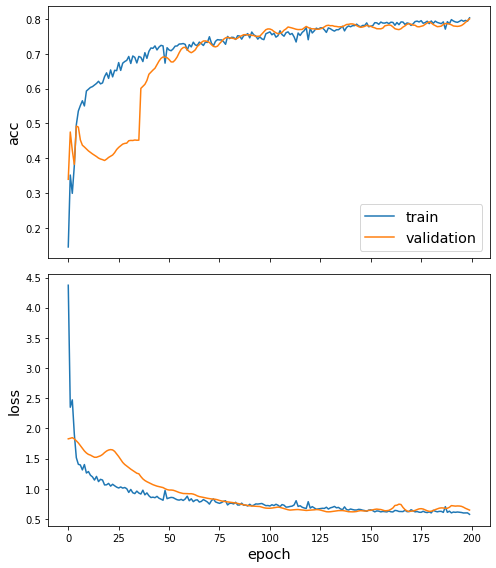

In [57]:
sg.utils.plot_history(history_gat)

In [58]:
test_metrics = model.evaluate(test_gen)

print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 1s 805ms/step - loss: 0.6740 - acc: 0.7961

Test Set Metrics:
	loss: 0.6740
	acc: 0.7961


In [59]:
y_pred = model.predict(test_gen)
y_pred = target_encoding.inverse_transform(y_pred.squeeze())
# y_pred = le.inverse_transform(y_pred)

y_pred[:10]

array(['Informatyka', 'Astronomia', 'Astronomia', 'Biologia',
       'Astronomia', 'Biologia', 'Astronomia', 'Matematyka', 'Fizyka',
       'Biologia'], dtype='<U11')

In [60]:
y_test = target_encoding.inverse_transform(test_targets)
# y_test = le.inverse_transform(y_test)

y_test[:10]

array(['Informatyka', 'Astronomia', 'Astronomia', 'Biologia',
       'Astronomia', 'Biologia', 'Astronomia', 'Matematyka', 'Biologia',
       'Biologia'], dtype='<U11')

In [61]:
with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_6_ft_results/gat_y_pred.pkl', 'wb') as f:
    pickle.dump(y_pred, f)

with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_6_ft_results/gat_y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Astronomia       0.91      0.99      0.95      3832
    Biologia       0.79      0.96      0.87      3522
      Chemia       0.52      0.42      0.47       416
      Fizyka       0.51      0.41      0.45       768
 Informatyka       0.62      0.54      0.57       738
  Matematyka       0.66      0.46      0.54      1211
 Psychologia       0.89      0.47      0.61       860

    accuracy                           0.80     11347
   macro avg       0.70      0.61      0.64     11347
weighted avg       0.78      0.80      0.78     11347



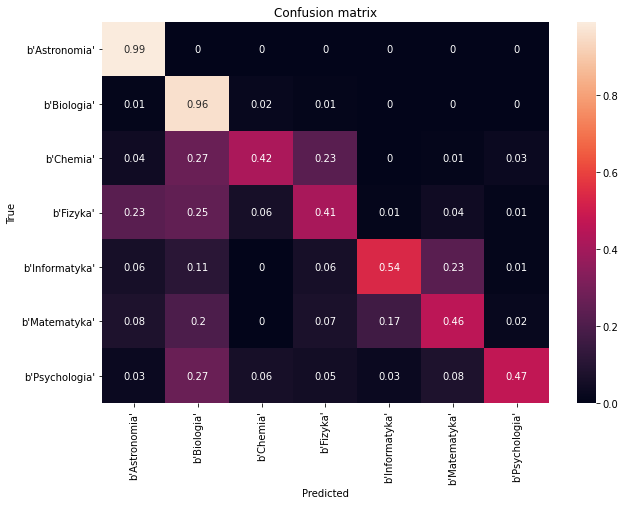

In [63]:
conf_matrix(
    y_true=y_test,
    y_pred=y_pred
)

### GCN

In [64]:
generator = FullBatchNodeGenerator(stellar_graph, method="gcn")

train_gen = generator.flow(train_subjects.index, train_targets)
test_gen = generator.flow(test_subjects.index, test_targets)
val_gen = generator.flow(val_subjects.index, val_targets)

Using GCN (local pooling) filters...


In [65]:
gcn = GCN(
    layer_sizes=[128, 128],
    activations=["elu","elu"],
    generator=generator,
    dropout=0.5
)

In [66]:
x_inp, x_out = gcn.in_out_tensors()

dense = tf.keras.layers.Dense(units=64, activation="relu")(x_out)
predictions = tf.keras.layers.Dense(units=train_targets.shape[1], activation="softmax")(dense)

In [67]:
model = Model(inputs=x_inp, outputs=predictions)

model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [68]:
# if not os.path.isdir("logs"):
#     os.makedirs("logs")
es_callback = EarlyStopping(
    monitor="val_acc", patience=20
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
# mc_callback = ModelCheckpoint(
#     "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
# )

In [69]:
history_gcn = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    # callbacks=[es_callback, mc_callback],
    # callbacks=[es_callback],
)

Epoch 1/200
1/1 - 1s - loss: 1.9460 - acc: 0.0817 - val_loss: 1.8859 - val_acc: 0.5516
Epoch 2/200
1/1 - 0s - loss: 1.8863 - acc: 0.5151 - val_loss: 1.8174 - val_acc: 0.5664
Epoch 3/200
1/1 - 0s - loss: 1.8185 - acc: 0.5462 - val_loss: 1.7442 - val_acc: 0.5645
Epoch 4/200
1/1 - 0s - loss: 1.7448 - acc: 0.5534 - val_loss: 1.6695 - val_acc: 0.5576
Epoch 5/200
1/1 - 0s - loss: 1.6635 - acc: 0.5588 - val_loss: 1.5849 - val_acc: 0.5677
Epoch 6/200
1/1 - 0s - loss: 1.5939 - acc: 0.5642 - val_loss: 1.4795 - val_acc: 0.5881
Epoch 7/200
1/1 - 0s - loss: 1.4878 - acc: 0.5851 - val_loss: 1.3746 - val_acc: 0.6173
Epoch 8/200
1/1 - 0s - loss: 1.3867 - acc: 0.5969 - val_loss: 1.2724 - val_acc: 0.6488
Epoch 9/200
1/1 - 0s - loss: 1.2802 - acc: 0.6431 - val_loss: 1.1715 - val_acc: 0.6675
Epoch 10/200
1/1 - 0s - loss: 1.1891 - acc: 0.6618 - val_loss: 1.0763 - val_acc: 0.6955
Epoch 11/200
1/1 - 0s - loss: 1.1257 - acc: 0.6632 - val_loss: 0.9956 - val_acc: 0.7066
Epoch 12/200
1/1 - 0s - loss: 1.0189 - ac

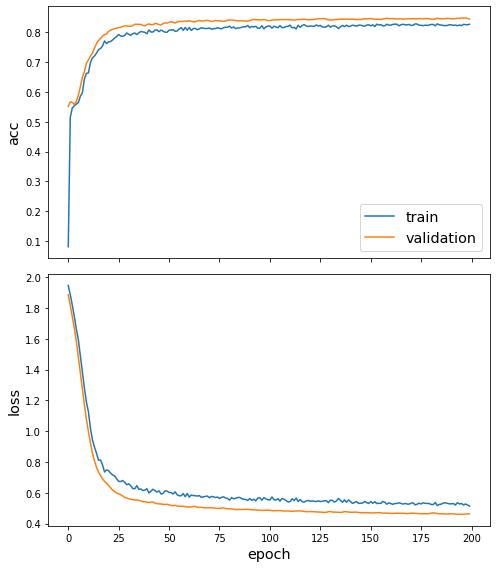

In [70]:
sg.utils.plot_history(history_gcn)

In [71]:
test_metrics = model.evaluate(test_gen)

print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 58ms/step - loss: 0.4783 - acc: 0.8414

Test Set Metrics:
	loss: 0.4783
	acc: 0.8414


In [72]:
y_pred = model.predict(test_gen)
y_pred = target_encoding.inverse_transform(y_pred.squeeze())
# y_pred = le.inverse_transform(y_pred)

y_pred[:10]

array(['Informatyka', 'Astronomia', 'Astronomia', 'Biologia',
       'Astronomia', 'Biologia', 'Astronomia', 'Matematyka', 'Fizyka',
       'Biologia'], dtype='<U11')

In [73]:
y_test = target_encoding.inverse_transform(test_targets)
# y_test = le.inverse_transform(y_test)

y_test[:10]

array(['Informatyka', 'Astronomia', 'Astronomia', 'Biologia',
       'Astronomia', 'Biologia', 'Astronomia', 'Matematyka', 'Biologia',
       'Biologia'], dtype='<U11')

In [74]:
with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_6_ft_results/gcn_y_pred.pkl', 'wb') as f:
    pickle.dump(y_pred, f)

with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_6_ft_results/gcn_y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

In [75]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Astronomia       0.98      0.98      0.98      3832
    Biologia       0.83      0.95      0.88      3522
      Chemia       0.61      0.49      0.55       416
      Fizyka       0.71      0.53      0.61       768
 Informatyka       0.63      0.73      0.68       738
  Matematyka       0.75      0.61      0.67      1211
 Psychologia       0.78      0.66      0.72       860

    accuracy                           0.84     11347
   macro avg       0.76      0.71      0.73     11347
weighted avg       0.84      0.84      0.84     11347



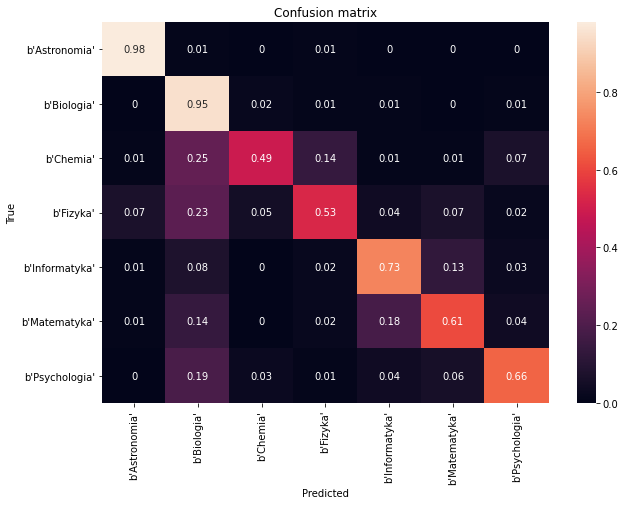

In [76]:
conf_matrix(
    y_true=y_test,
    y_pred=y_pred
)

# Inne

In [ ]:
import glob
import itertools
from os.path import join
import pickle
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import stellargraph as sg
import tensorflow as tf
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from stellargraph import StellarGraph
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT, GCN
from tensorflow.keras import layers, models, optimizers, losses, metrics, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from torch.utils import data as data_utils
from tqdm import tqdm

from google.colab import drive

tqdm.pandas()



import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report

from google.colab import drive

In [ ]:
with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_2_results/nn_y_pred.pkl', 'rb') as f:
    gcn_2_nn_pred = pickle.load(f)

with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_2_results/nn_y_test.pkl', 'rb') as f:
    gcn_2_nn_true = pickle.load(f)

with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_2_results/gat_y_pred.pkl', 'rb') as f:
    gcn_2_gat_pred = pickle.load(f)

with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_2_results/gat_y_test.pkl', 'rb') as f:
    gcn_2_gat_true = pickle.load(f)

with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_2_results/gcn_y_pred.pkl', 'rb') as f:
    gcn_2_gcn_pred = pickle.load(f)

with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_2_results/gcn_y_test.pkl', 'rb') as f:
    gcn_2_gcn_true = pickle.load(f)

# ---------------------------------------------------------------------------------------------
with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_3_results/onehot140_base_y_pred.pickle', 'rb') as f:
    gcn_3_nn_pred = pickle.load(f)

with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_3_results/onehot140_base_y_true.pickle', 'rb') as f:
    gcn_3_nn_true = pickle.load(f)

with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_3_results/onehot140_gat_y_pred.pickle', 'rb') as f:
    gcn_3_gat_pred = pickle.load(f)

with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_3_results/onehot140_gat_y_true.pickle', 'rb') as f:
    gcn_3_gat_true = pickle.load(f)

with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_3_results/onehot140_gcn_y_pred.pickle', 'rb') as f:
    gcn_3_gcn_pred = pickle.load(f)

with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_3_results/onehot140_gcn_y_true.pickle', 'rb') as f:
    gcn_3_gcn_true = pickle.load(f)

In [ ]:
def get_classification_report(y_true, y_pred):
    print(classification_report(y_true, y_pred))


def get_conf_matrix(y_true, y_pred):
    labels = tf.unique(y_true)[0].numpy()
    labels.sort()

    con_mat = confusion_matrix(y_true, y_pred)
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

    df_cm = pd.DataFrame(con_mat_norm,
                        index = labels, 
                        columns = [i for i in labels])

    plt.figure(figsize = (10,7))
    plt.title("Confusion matrix")
    sn.heatmap(df_cm, annot=True, fmt='g')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

## Podejście 1 - NN

              precision    recall  f1-score   support

  Astronomia       0.98      0.98      0.98      3830
    Biologia       0.96      0.97      0.97      3509
      Chemia       0.62      0.75      0.68       409
      Fizyka       0.78      0.73      0.75       760
 Informatyka       0.69      0.77      0.73       732
  Matematyka       0.82      0.72      0.77      1200
 Psychologia       0.81      0.81      0.81       855

    accuracy                           0.90     11295
   macro avg       0.81      0.82      0.81     11295
weighted avg       0.90      0.90      0.90     11295



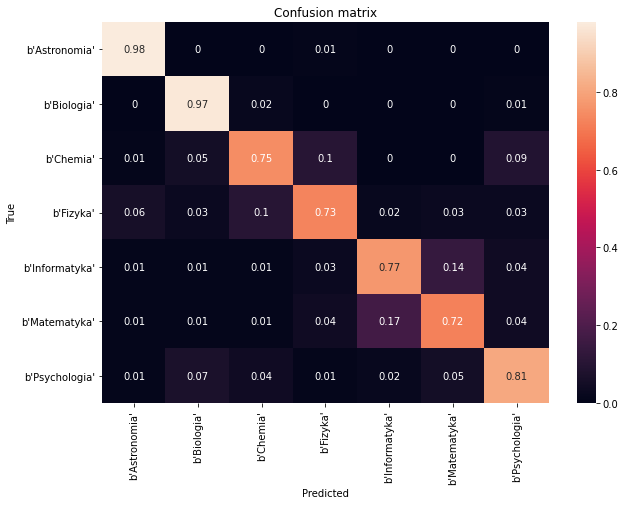

In [ ]:
get_classification_report(gcn_2_nn_true, gcn_2_nn_pred)

get_conf_matrix(gcn_2_nn_true, gcn_2_nn_pred)

              precision    recall  f1-score   support

  Astronomia       0.98      0.99      0.98      3832
    Biologia       0.88      0.97      0.92      3522
      Chemia       0.71      0.53      0.61       416
      Fizyka       0.79      0.69      0.74       768
 Informatyka       0.77      0.75      0.76       738
  Matematyka       0.81      0.75      0.78      1211
 Psychologia       0.85      0.74      0.79       860

    accuracy                           0.89     11347
   macro avg       0.83      0.78      0.80     11347
weighted avg       0.88      0.89      0.88     11347



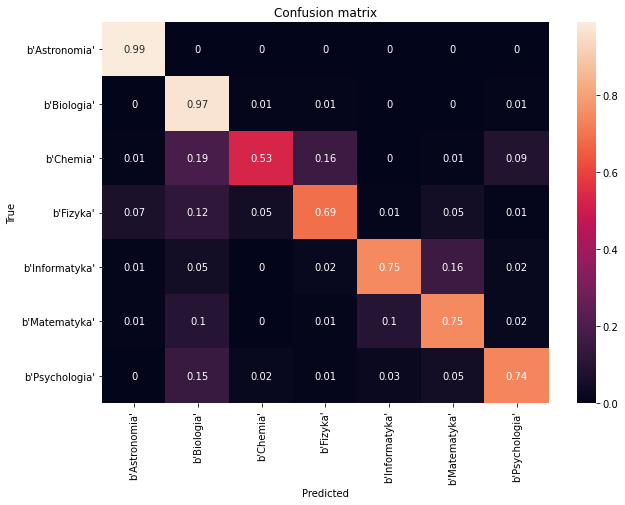

In [ ]:
get_classification_report(gcn_3_gat_true, gcn_3_gat_pred)

get_conf_matrix(gcn_3_gat_true, gcn_3_gat_pred)

              precision    recall  f1-score   support

  Astronomia       0.99      0.99      0.99      3832
    Biologia       0.88      0.97      0.92      3522
      Chemia       0.65      0.55      0.60       416
      Fizyka       0.77      0.70      0.74       768
 Informatyka       0.75      0.74      0.74       738
  Matematyka       0.82      0.73      0.77      1211
 Psychologia       0.83      0.73      0.78       860

    accuracy                           0.88     11347
   macro avg       0.81      0.77      0.79     11347
weighted avg       0.88      0.88      0.88     11347



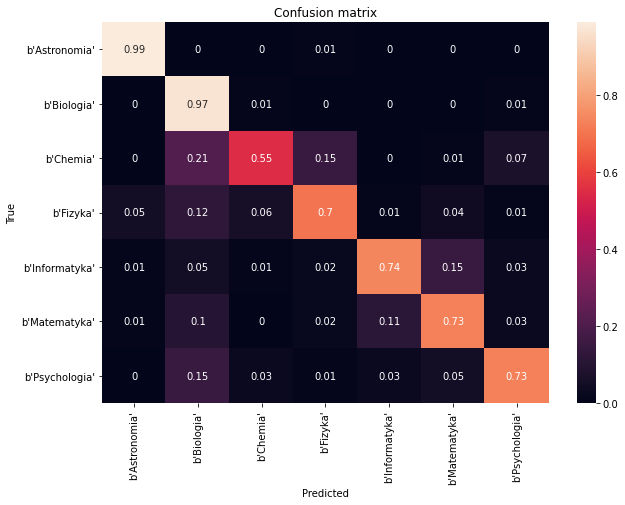

In [ ]:
get_classification_report(gcn_3_gcn_true, gcn_3_gcn_pred)

get_conf_matrix(gcn_3_gcn_true, gcn_3_gcn_pred)

## Podejście 2